# Interpretability tutorial

In this tutorial we will go through several popular visualization techniques that help interpret deep learning networks.

We will cover:
1. Filter visualization
2. Feature/ activation visualization with PyTorch hooks
3. CNN Layer Visualization
4. Gradient visualization with Guided backpropagation
5. Gradient Class Activation Maps (grad-CAM)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np 
import visualizations
from visualizations.src.misc_functions import *
from visualizations.src.guided_backprop import GuidedBackprop
from visualizations.src.cnn_layer_visualization import CNNLayerVisualization
from visualizations.src.gradcam import GradCam
from visualizations.src.deep_dream import DeepDream

device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")



## Exercise 1. Weights Visualization

https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e

https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb#scrollTo=uQI9jHcP6xfP

One of the first things you can visualize in your network - is your network weights.
Your convolutional kernels have weights which are updated during training, and can be visualized by calling the weight data inside your network.

Let's first load and print a pretrained network using pytorch.models:

In [2]:
# first load pretrained alxenet model
alexnet = models.alexnet(pretrained=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We can see that the network is made up of two sequential models - features, and classifier.

To visualize the convolutional weights, we need to access a convolutional layer in the features model.

This can be done in the following way:
```python 
weight_tensor = model.features[layer_num].weight.data
```
**Note that layer_num should correspond to a convolutional layer - otherwise there are no weights to be visualized.**

We will now define a few functions to help with plotting:

In [3]:
def plot_filters_single_channel(t):
    
    kernels_to_plot = 30
    channels_to_plot = 3
    #total kernels depth * number of kernels
    nplots = channels_to_plot*kernels_to_plot
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(kernels_to_plot):
        for j in range(channels_to_plot):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()    

    
def plot_filters_multi_channel(t):
    
    kernels_to_plot = 60
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = kernels_to_plot // num_cols
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(kernels_to_plot):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.tight_layout()
    plt.show()
    


We next define our plot weights function, which first extracts the weights of a convolutional filter, and then passes into an appropriate image plotting function.

### Task 1.1 - edit the `plot_weights` function to return the weights tensor corresponding to layer `layer_num`

In [4]:
def plot_weights(model, layer_num, single_channel = True):
    #extracting the model features at the particular layer number
    layer = model.features[layer_num]
  
    #checking whether the layer is convolution layer or not 

    if isinstance(layer, nn.Conv2d):
        #getting the weight tensor data
        weight_tensor = model.features[layer_num].weight.data
        print('weight_tensor.shape',weight_tensor.shape)
        if single_channel:
            plot_filters_single_channel(weight_tensor)
        
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels with single channel = False")
        
    else:
        print("Can only visualize layers which are convolutional")


### Task 1.2 Explain 

- what do the weights of your network represent? 
- what is the difference between a kernel and a filter (**hint** see lecture 4)
- Layer 3 (the second convolution) has a weights matrix of size `[192, 64, 5, 5]`. What does each dimension represent? How many filters does it learn, how many kernels?

#### Answer here:

### Task 1.3  Visualise weights for different layers.

- plot the weights for different colvolutional layers
- Note the purpose of parameter `single_channel=False` is to plot all filters as a single image. **However** this is only possible for 3 channel output - where it can be plotted in RGB; 
- try plotting the output of the first layer with `single_channel=True`, then `single_channel=False` to see the difference
- What do the numbers above the plots mean? How many outputs are being returned and why (**hint** check the plotting functions)? How do you determine how many 
- try editing the plotting functions to include input arguments which vary the numbers of kernels plot per filter for each layer

weight_tensor.shape torch.Size([384, 192, 3, 3])


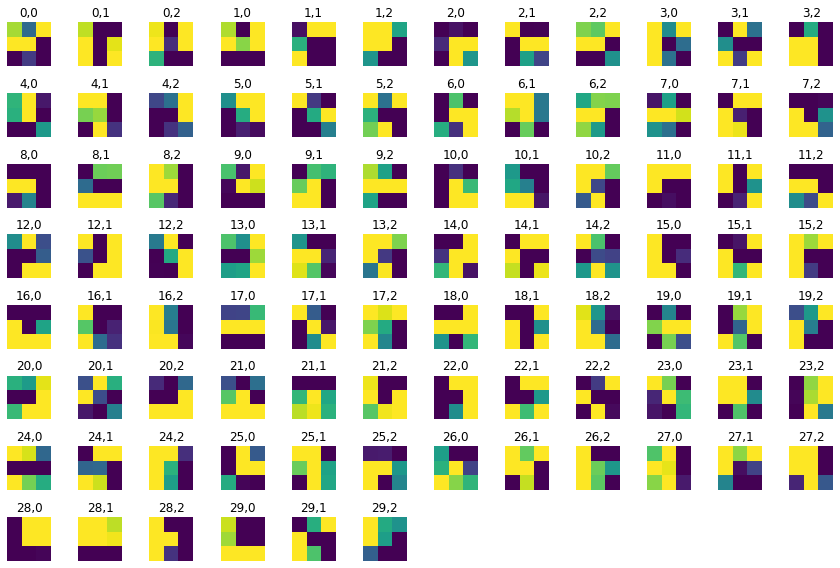

In [5]:
#visualize weights for alexnet - first conv layer
plot_weights(alexnet, 6, single_channel = True)

## Exercise 2. Activation visualization with PyTorch Hooks

Another effective approach to examine what your network is learning, is the visualize your network's features or activations, i.e. intermediate outputs of your network for a specific inputs. 

In the following example, we set up a simple autoencoder network, a network that learns to reconstruct an input, using the MNIST dataset. 

https://discuss.pytorch.org/t/visualize-feature-map/29597/2

### Set up and train a simple autoencoder

An autoencoder is a network with an encoder and decoder structure similar to a U-Net but with a loss designed for reconstruction, and no skip connections (of course, technically autoencoders came first, so officially U-Net are inpired by autoencoders not the other way round!). Here, the encoder learns a compressed representation of the image such that the bottleneck layer (output of encoder) retains the minimal information needed to reconstruct the image. This means that autoencoders have traditonally been used for denoising, although as you will see they tend to lose high frequency information (hence U-Nets skip connections). Below we show an example of an autoencoder architecture 

<img src="autoencoder.png" alt="Drawing" style="width: 400px;"/>

First we load the data


In [3]:
dataset = datasets.MNIST(
    root="data",download=True,
    transform=transforms.ToTensor()
)

loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=8,
    shuffle=True
)

In [ ]:
Now we set up a simple autoncoder for MNIST reconsrtuction (using torchvision). 

**Check through the code such that you know what each line is doing, and that you understand the choice of optimizer, and loss function**

In [6]:
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(3, 6, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv_trans1 = nn.ConvTranspose2d(6, 3, 4, 2, 1)
        self.conv_trans2 = nn.ConvTranspose2d(3, 1, 4, 2, 1)
        
    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))        
        x = F.relu(self.conv_trans1(x))
        x = self.conv_trans2(x)
        return x

# normalisation - for plotting output
def min_max_norm(img):
    img = img - img.min()
    img = img / img.max()
    return img

dataset = datasets.MNIST(
    root="data",download=True,
    transform=transforms.ToTensor()
)

loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=8,
    shuffle=True
)

# initialize the network, loss function and optimizer 
model = SimpleAutoencoder()
criterion_l1 = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Train our simple network on MNIST

In [7]:
epochs = 1
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion_l1(output, data)
        loss.backward()
        optimizer.step()
        
        print('Epoch {}, Iteration {}, loss {}'.format(
            epoch, batch_idx, loss.item()))


Epoch 0, Iteration 0, loss 0.6527500152587891
Epoch 0, Iteration 1, loss 0.6529694199562073
Epoch 0, Iteration 2, loss 0.6511351466178894
Epoch 0, Iteration 3, loss 0.6529825925827026
Epoch 0, Iteration 4, loss 0.647057056427002
Epoch 0, Iteration 5, loss 0.6480785012245178
Epoch 0, Iteration 6, loss 0.6505933403968811
Epoch 0, Iteration 7, loss 0.6470634937286377
Epoch 0, Iteration 8, loss 0.6448821425437927
Epoch 0, Iteration 9, loss 0.6439197063446045
Epoch 0, Iteration 10, loss 0.6429318189620972
Epoch 0, Iteration 11, loss 0.6441736221313477
Epoch 0, Iteration 12, loss 0.6402564644813538
Epoch 0, Iteration 13, loss 0.6384309530258179
Epoch 0, Iteration 14, loss 0.6379042863845825
Epoch 0, Iteration 15, loss 0.6358594298362732
Epoch 0, Iteration 16, loss 0.6327099800109863
Epoch 0, Iteration 17, loss 0.6375135779380798
Epoch 0, Iteration 18, loss 0.6292724609375
Epoch 0, Iteration 19, loss 0.6338196992874146
Epoch 0, Iteration 20, loss 0.6227547526359558
Epoch 0, Iteration 21, loss

Epoch 0, Iteration 185, loss 0.37596815824508667
Epoch 0, Iteration 186, loss 0.35839948058128357
Epoch 0, Iteration 187, loss 0.3511742055416107
Epoch 0, Iteration 188, loss 0.38921403884887695
Epoch 0, Iteration 189, loss 0.3459804356098175
Epoch 0, Iteration 190, loss 0.37563109397888184
Epoch 0, Iteration 191, loss 0.336730420589447
Epoch 0, Iteration 192, loss 0.38406628370285034
Epoch 0, Iteration 193, loss 0.3536457121372223
Epoch 0, Iteration 194, loss 0.3496532142162323
Epoch 0, Iteration 195, loss 0.33714559674263
Epoch 0, Iteration 196, loss 0.34612172842025757
Epoch 0, Iteration 197, loss 0.32609811425209045
Epoch 0, Iteration 198, loss 0.34252190589904785
Epoch 0, Iteration 199, loss 0.39321810007095337
Epoch 0, Iteration 200, loss 0.31963926553726196
Epoch 0, Iteration 201, loss 0.2847028374671936
Epoch 0, Iteration 202, loss 0.35783693194389343
Epoch 0, Iteration 203, loss 0.3693156838417053
Epoch 0, Iteration 204, loss 0.3567213714122772
Epoch 0, Iteration 205, loss 0.2

Epoch 0, Iteration 376, loss 0.13919946551322937
Epoch 0, Iteration 377, loss 0.15129956603050232
Epoch 0, Iteration 378, loss 0.15630905330181122
Epoch 0, Iteration 379, loss 0.13423138856887817
Epoch 0, Iteration 380, loss 0.17324963212013245
Epoch 0, Iteration 381, loss 0.15865063667297363
Epoch 0, Iteration 382, loss 0.17714695632457733
Epoch 0, Iteration 383, loss 0.15813007950782776
Epoch 0, Iteration 384, loss 0.1195022240281105
Epoch 0, Iteration 385, loss 0.144517183303833
Epoch 0, Iteration 386, loss 0.15928292274475098
Epoch 0, Iteration 387, loss 0.15094393491744995
Epoch 0, Iteration 388, loss 0.1387907713651657
Epoch 0, Iteration 389, loss 0.147962749004364
Epoch 0, Iteration 390, loss 0.16857784986495972
Epoch 0, Iteration 391, loss 0.15150833129882812
Epoch 0, Iteration 392, loss 0.15776707231998444
Epoch 0, Iteration 393, loss 0.15767943859100342
Epoch 0, Iteration 394, loss 0.13108882308006287
Epoch 0, Iteration 395, loss 0.15576711297035217
Epoch 0, Iteration 396, lo

Epoch 0, Iteration 588, loss 0.15148136019706726
Epoch 0, Iteration 589, loss 0.1347331702709198
Epoch 0, Iteration 590, loss 0.11672692745923996
Epoch 0, Iteration 591, loss 0.12422144412994385
Epoch 0, Iteration 592, loss 0.11114693433046341
Epoch 0, Iteration 593, loss 0.10976975411176682
Epoch 0, Iteration 594, loss 0.14552095532417297
Epoch 0, Iteration 595, loss 0.1021546944975853
Epoch 0, Iteration 596, loss 0.1133122518658638
Epoch 0, Iteration 597, loss 0.12693950533866882
Epoch 0, Iteration 598, loss 0.13770009577274323
Epoch 0, Iteration 599, loss 0.11156833171844482
Epoch 0, Iteration 600, loss 0.12690241634845734
Epoch 0, Iteration 601, loss 0.11286987364292145
Epoch 0, Iteration 602, loss 0.10418065637350082
Epoch 0, Iteration 603, loss 0.12454122304916382
Epoch 0, Iteration 604, loss 0.13680590689182281
Epoch 0, Iteration 605, loss 0.15391434729099274
Epoch 0, Iteration 606, loss 0.13300727307796478
Epoch 0, Iteration 607, loss 0.08416280150413513
Epoch 0, Iteration 608,

Epoch 0, Iteration 759, loss 0.10190077126026154
Epoch 0, Iteration 760, loss 0.12265223264694214
Epoch 0, Iteration 761, loss 0.12795613706111908
Epoch 0, Iteration 762, loss 0.10274619609117508
Epoch 0, Iteration 763, loss 0.10122665762901306
Epoch 0, Iteration 764, loss 0.11494304984807968
Epoch 0, Iteration 765, loss 0.11690448969602585
Epoch 0, Iteration 766, loss 0.10263655334711075
Epoch 0, Iteration 767, loss 0.11809647083282471
Epoch 0, Iteration 768, loss 0.11315695941448212
Epoch 0, Iteration 769, loss 0.11076777428388596
Epoch 0, Iteration 770, loss 0.11641249060630798
Epoch 0, Iteration 771, loss 0.10820258408784866
Epoch 0, Iteration 772, loss 0.10818302631378174
Epoch 0, Iteration 773, loss 0.12906278669834137
Epoch 0, Iteration 774, loss 0.09114176034927368
Epoch 0, Iteration 775, loss 0.10586776584386826
Epoch 0, Iteration 776, loss 0.09686311334371567
Epoch 0, Iteration 777, loss 0.0872262641787529
Epoch 0, Iteration 778, loss 0.11535027623176575
Epoch 0, Iteration 77

Epoch 0, Iteration 930, loss 0.11292971670627594
Epoch 0, Iteration 931, loss 0.11986891180276871
Epoch 0, Iteration 932, loss 0.11232902854681015
Epoch 0, Iteration 933, loss 0.07946471124887466
Epoch 0, Iteration 934, loss 0.11679897457361221
Epoch 0, Iteration 935, loss 0.10269845277070999
Epoch 0, Iteration 936, loss 0.10778997093439102
Epoch 0, Iteration 937, loss 0.1137256994843483
Epoch 0, Iteration 938, loss 0.11456528306007385
Epoch 0, Iteration 939, loss 0.10905830562114716
Epoch 0, Iteration 940, loss 0.10608542710542679
Epoch 0, Iteration 941, loss 0.09678096324205399
Epoch 0, Iteration 942, loss 0.08999983221292496
Epoch 0, Iteration 943, loss 0.10720371454954147
Epoch 0, Iteration 944, loss 0.10681334137916565
Epoch 0, Iteration 945, loss 0.0984245017170906
Epoch 0, Iteration 946, loss 0.11789840459823608
Epoch 0, Iteration 947, loss 0.11860523372888565
Epoch 0, Iteration 948, loss 0.11033695936203003
Epoch 0, Iteration 949, loss 0.11008375883102417
Epoch 0, Iteration 950

Epoch 0, Iteration 1107, loss 0.1032678633928299
Epoch 0, Iteration 1108, loss 0.11039639264345169
Epoch 0, Iteration 1109, loss 0.09702584892511368
Epoch 0, Iteration 1110, loss 0.10081809014081955
Epoch 0, Iteration 1111, loss 0.09973981231451035
Epoch 0, Iteration 1112, loss 0.11138853430747986
Epoch 0, Iteration 1113, loss 0.10501790791749954
Epoch 0, Iteration 1114, loss 0.10355725884437561
Epoch 0, Iteration 1115, loss 0.09879150241613388
Epoch 0, Iteration 1116, loss 0.0991259291768074
Epoch 0, Iteration 1117, loss 0.10905064642429352
Epoch 0, Iteration 1118, loss 0.11779607832431793
Epoch 0, Iteration 1119, loss 0.10775569826364517
Epoch 0, Iteration 1120, loss 0.09211421757936478
Epoch 0, Iteration 1121, loss 0.12199195474386215
Epoch 0, Iteration 1122, loss 0.1110142171382904
Epoch 0, Iteration 1123, loss 0.08712749183177948
Epoch 0, Iteration 1124, loss 0.11577004194259644
Epoch 0, Iteration 1125, loss 0.09291255474090576
Epoch 0, Iteration 1126, loss 0.10361263900995255
Epo

Epoch 0, Iteration 1303, loss 0.10694018006324768
Epoch 0, Iteration 1304, loss 0.09043000638484955
Epoch 0, Iteration 1305, loss 0.09606478363275528
Epoch 0, Iteration 1306, loss 0.10046841949224472
Epoch 0, Iteration 1307, loss 0.1004486009478569
Epoch 0, Iteration 1308, loss 0.0990019217133522
Epoch 0, Iteration 1309, loss 0.08293458074331284
Epoch 0, Iteration 1310, loss 0.09609232097864151
Epoch 0, Iteration 1311, loss 0.11544281989336014
Epoch 0, Iteration 1312, loss 0.10406184941530228
Epoch 0, Iteration 1313, loss 0.09759468585252762
Epoch 0, Iteration 1314, loss 0.10292209684848785
Epoch 0, Iteration 1315, loss 0.08939885348081589
Epoch 0, Iteration 1316, loss 0.1107800155878067
Epoch 0, Iteration 1317, loss 0.10981400310993195
Epoch 0, Iteration 1318, loss 0.10779976099729538
Epoch 0, Iteration 1319, loss 0.10769890993833542
Epoch 0, Iteration 1320, loss 0.09831539541482925
Epoch 0, Iteration 1321, loss 0.12791071832180023
Epoch 0, Iteration 1322, loss 0.10819035768508911
Epo

Epoch 0, Iteration 1501, loss 0.08893130719661713
Epoch 0, Iteration 1502, loss 0.11901840567588806
Epoch 0, Iteration 1503, loss 0.10787595063447952
Epoch 0, Iteration 1504, loss 0.08806438744068146
Epoch 0, Iteration 1505, loss 0.0949394628405571
Epoch 0, Iteration 1506, loss 0.107065349817276
Epoch 0, Iteration 1507, loss 0.11452976614236832
Epoch 0, Iteration 1508, loss 0.10516968369483948
Epoch 0, Iteration 1509, loss 0.09969421476125717
Epoch 0, Iteration 1510, loss 0.09356395900249481
Epoch 0, Iteration 1511, loss 0.11409182101488113
Epoch 0, Iteration 1512, loss 0.09609514474868774
Epoch 0, Iteration 1513, loss 0.09588246792554855
Epoch 0, Iteration 1514, loss 0.11177569627761841
Epoch 0, Iteration 1515, loss 0.11172603815793991
Epoch 0, Iteration 1516, loss 0.10731133818626404
Epoch 0, Iteration 1517, loss 0.09402786940336227
Epoch 0, Iteration 1518, loss 0.10449054092168808
Epoch 0, Iteration 1519, loss 0.1003720834851265
Epoch 0, Iteration 1520, loss 0.09939461201429367
Epoc

Epoch 0, Iteration 1699, loss 0.09726225584745407
Epoch 0, Iteration 1700, loss 0.1036023199558258
Epoch 0, Iteration 1701, loss 0.09858379513025284
Epoch 0, Iteration 1702, loss 0.0754772201180458
Epoch 0, Iteration 1703, loss 0.09693101048469543
Epoch 0, Iteration 1704, loss 0.10150443017482758
Epoch 0, Iteration 1705, loss 0.11544862389564514
Epoch 0, Iteration 1706, loss 0.0941033661365509
Epoch 0, Iteration 1707, loss 0.09473054111003876
Epoch 0, Iteration 1708, loss 0.10411542654037476
Epoch 0, Iteration 1709, loss 0.10373983532190323
Epoch 0, Iteration 1710, loss 0.08470676094293594
Epoch 0, Iteration 1711, loss 0.11293042451143265
Epoch 0, Iteration 1712, loss 0.08684000372886658
Epoch 0, Iteration 1713, loss 0.09649033099412918
Epoch 0, Iteration 1714, loss 0.0919799730181694
Epoch 0, Iteration 1715, loss 0.0830129012465477
Epoch 0, Iteration 1716, loss 0.11072705686092377
Epoch 0, Iteration 1717, loss 0.0873304158449173
Epoch 0, Iteration 1718, loss 0.09760366380214691
Epoch 

Epoch 0, Iteration 1897, loss 0.09270717948675156
Epoch 0, Iteration 1898, loss 0.09618882089853287
Epoch 0, Iteration 1899, loss 0.096483513712883
Epoch 0, Iteration 1900, loss 0.10219743102788925
Epoch 0, Iteration 1901, loss 0.10092760622501373
Epoch 0, Iteration 1902, loss 0.09551694244146347
Epoch 0, Iteration 1903, loss 0.06952835619449615
Epoch 0, Iteration 1904, loss 0.10903917998075485
Epoch 0, Iteration 1905, loss 0.08031148463487625
Epoch 0, Iteration 1906, loss 0.0935196503996849
Epoch 0, Iteration 1907, loss 0.09148737788200378
Epoch 0, Iteration 1908, loss 0.10361457616090775
Epoch 0, Iteration 1909, loss 0.09417719393968582
Epoch 0, Iteration 1910, loss 0.11029411852359772
Epoch 0, Iteration 1911, loss 0.11138486862182617
Epoch 0, Iteration 1912, loss 0.09694896638393402
Epoch 0, Iteration 1913, loss 0.0898505300283432
Epoch 0, Iteration 1914, loss 0.12096992880105972
Epoch 0, Iteration 1915, loss 0.09088484942913055
Epoch 0, Iteration 1916, loss 0.09679088741540909
Epoc

Epoch 0, Iteration 2098, loss 0.0932842567563057
Epoch 0, Iteration 2099, loss 0.08903518319129944
Epoch 0, Iteration 2100, loss 0.08526861667633057
Epoch 0, Iteration 2101, loss 0.08673664182424545
Epoch 0, Iteration 2102, loss 0.09397748857736588
Epoch 0, Iteration 2103, loss 0.0875648781657219
Epoch 0, Iteration 2104, loss 0.11359905451536179
Epoch 0, Iteration 2105, loss 0.09269557893276215
Epoch 0, Iteration 2106, loss 0.09398934990167618
Epoch 0, Iteration 2107, loss 0.10034679621458054
Epoch 0, Iteration 2108, loss 0.10616222769021988
Epoch 0, Iteration 2109, loss 0.09222738444805145
Epoch 0, Iteration 2110, loss 0.07475730031728745
Epoch 0, Iteration 2111, loss 0.09018129855394363
Epoch 0, Iteration 2112, loss 0.10596306622028351
Epoch 0, Iteration 2113, loss 0.09453713148832321
Epoch 0, Iteration 2114, loss 0.11695143580436707
Epoch 0, Iteration 2115, loss 0.08001722395420074
Epoch 0, Iteration 2116, loss 0.10785723477602005
Epoch 0, Iteration 2117, loss 0.10162095725536346
Ep

Epoch 0, Iteration 2290, loss 0.10632437467575073
Epoch 0, Iteration 2291, loss 0.0952925980091095
Epoch 0, Iteration 2292, loss 0.09382505714893341
Epoch 0, Iteration 2293, loss 0.09678208082914352
Epoch 0, Iteration 2294, loss 0.07692138850688934
Epoch 0, Iteration 2295, loss 0.09320557862520218
Epoch 0, Iteration 2296, loss 0.08980684727430344
Epoch 0, Iteration 2297, loss 0.10220556706190109
Epoch 0, Iteration 2298, loss 0.0991189107298851
Epoch 0, Iteration 2299, loss 0.0929558202624321
Epoch 0, Iteration 2300, loss 0.09559809416532516
Epoch 0, Iteration 2301, loss 0.09095381945371628
Epoch 0, Iteration 2302, loss 0.09010051935911179
Epoch 0, Iteration 2303, loss 0.09671536087989807
Epoch 0, Iteration 2304, loss 0.09538023918867111
Epoch 0, Iteration 2305, loss 0.10219460725784302
Epoch 0, Iteration 2306, loss 0.08790332078933716
Epoch 0, Iteration 2307, loss 0.08974090963602066
Epoch 0, Iteration 2308, loss 0.09252960979938507
Epoch 0, Iteration 2309, loss 0.08285108953714371
Epo

Epoch 0, Iteration 2461, loss 0.09512609243392944
Epoch 0, Iteration 2462, loss 0.08785242587327957
Epoch 0, Iteration 2463, loss 0.09673411399126053
Epoch 0, Iteration 2464, loss 0.07735041528940201
Epoch 0, Iteration 2465, loss 0.10233121365308762
Epoch 0, Iteration 2466, loss 0.09186670929193497
Epoch 0, Iteration 2467, loss 0.09336116164922714
Epoch 0, Iteration 2468, loss 0.08376266807317734
Epoch 0, Iteration 2469, loss 0.09849026054143906
Epoch 0, Iteration 2470, loss 0.08652731776237488
Epoch 0, Iteration 2471, loss 0.08261788636445999
Epoch 0, Iteration 2472, loss 0.09618095308542252
Epoch 0, Iteration 2473, loss 0.08994311094284058
Epoch 0, Iteration 2474, loss 0.0836176797747612
Epoch 0, Iteration 2475, loss 0.10862140357494354
Epoch 0, Iteration 2476, loss 0.09835407882928848
Epoch 0, Iteration 2477, loss 0.07763110101222992
Epoch 0, Iteration 2478, loss 0.0940200686454773
Epoch 0, Iteration 2479, loss 0.10881584882736206
Epoch 0, Iteration 2480, loss 0.09974205493927002
Ep

Epoch 0, Iteration 2663, loss 0.0947297066450119
Epoch 0, Iteration 2664, loss 0.08457564562559128
Epoch 0, Iteration 2665, loss 0.09948810935020447
Epoch 0, Iteration 2666, loss 0.0872141420841217
Epoch 0, Iteration 2667, loss 0.10099399089813232
Epoch 0, Iteration 2668, loss 0.09166739135980606
Epoch 0, Iteration 2669, loss 0.07989107072353363
Epoch 0, Iteration 2670, loss 0.10568265616893768
Epoch 0, Iteration 2671, loss 0.09128803759813309
Epoch 0, Iteration 2672, loss 0.08674322068691254
Epoch 0, Iteration 2673, loss 0.0977712944149971
Epoch 0, Iteration 2674, loss 0.08703170716762543
Epoch 0, Iteration 2675, loss 0.08055287599563599
Epoch 0, Iteration 2676, loss 0.0957726240158081
Epoch 0, Iteration 2677, loss 0.09517749398946762
Epoch 0, Iteration 2678, loss 0.10613425821065903
Epoch 0, Iteration 2679, loss 0.09179268777370453
Epoch 0, Iteration 2680, loss 0.08665937930345535
Epoch 0, Iteration 2681, loss 0.09485768526792526
Epoch 0, Iteration 2682, loss 0.09280175715684891
Epoc

Epoch 0, Iteration 2853, loss 0.10017284750938416
Epoch 0, Iteration 2854, loss 0.08193357288837433
Epoch 0, Iteration 2855, loss 0.09640751779079437
Epoch 0, Iteration 2856, loss 0.09487408399581909
Epoch 0, Iteration 2857, loss 0.08340521901845932
Epoch 0, Iteration 2858, loss 0.08654025942087173
Epoch 0, Iteration 2859, loss 0.09773039072751999
Epoch 0, Iteration 2860, loss 0.09164103865623474
Epoch 0, Iteration 2861, loss 0.09545205533504486
Epoch 0, Iteration 2862, loss 0.10568500310182571
Epoch 0, Iteration 2863, loss 0.09065504372119904
Epoch 0, Iteration 2864, loss 0.08887692540884018
Epoch 0, Iteration 2865, loss 0.09824500977993011
Epoch 0, Iteration 2866, loss 0.10832693427801132
Epoch 0, Iteration 2867, loss 0.10228323191404343
Epoch 0, Iteration 2868, loss 0.09675944596529007
Epoch 0, Iteration 2869, loss 0.07571154832839966
Epoch 0, Iteration 2870, loss 0.09295224398374557
Epoch 0, Iteration 2871, loss 0.10259603708982468
Epoch 0, Iteration 2872, loss 0.09074895083904266


Epoch 0, Iteration 3045, loss 0.09926967322826385
Epoch 0, Iteration 3046, loss 0.09876630455255508
Epoch 0, Iteration 3047, loss 0.09197747707366943
Epoch 0, Iteration 3048, loss 0.09721165150403976
Epoch 0, Iteration 3049, loss 0.09059254080057144
Epoch 0, Iteration 3050, loss 0.09604962170124054
Epoch 0, Iteration 3051, loss 0.10576801002025604
Epoch 0, Iteration 3052, loss 0.11270147562026978
Epoch 0, Iteration 3053, loss 0.0780116468667984
Epoch 0, Iteration 3054, loss 0.08757304400205612
Epoch 0, Iteration 3055, loss 0.08978491276502609
Epoch 0, Iteration 3056, loss 0.10598629713058472
Epoch 0, Iteration 3057, loss 0.08599136024713516
Epoch 0, Iteration 3058, loss 0.07257416099309921
Epoch 0, Iteration 3059, loss 0.10190819948911667
Epoch 0, Iteration 3060, loss 0.09806201606988907
Epoch 0, Iteration 3061, loss 0.1026303842663765
Epoch 0, Iteration 3062, loss 0.10452624410390854
Epoch 0, Iteration 3063, loss 0.09811823815107346
Epoch 0, Iteration 3064, loss 0.09708337485790253
Ep

Epoch 0, Iteration 3244, loss 0.08040187507867813
Epoch 0, Iteration 3245, loss 0.09591690450906754
Epoch 0, Iteration 3246, loss 0.0680963471531868
Epoch 0, Iteration 3247, loss 0.08331754058599472
Epoch 0, Iteration 3248, loss 0.08662427961826324
Epoch 0, Iteration 3249, loss 0.09831438213586807
Epoch 0, Iteration 3250, loss 0.08202482014894485
Epoch 0, Iteration 3251, loss 0.10744262486696243
Epoch 0, Iteration 3252, loss 0.10290888696908951
Epoch 0, Iteration 3253, loss 0.09287233650684357
Epoch 0, Iteration 3254, loss 0.09906186908483505
Epoch 0, Iteration 3255, loss 0.0840049758553505
Epoch 0, Iteration 3256, loss 0.0950814038515091
Epoch 0, Iteration 3257, loss 0.08647692203521729
Epoch 0, Iteration 3258, loss 0.0868925154209137
Epoch 0, Iteration 3259, loss 0.0850493535399437
Epoch 0, Iteration 3260, loss 0.08928696811199188
Epoch 0, Iteration 3261, loss 0.09509925544261932
Epoch 0, Iteration 3262, loss 0.09978174418210983
Epoch 0, Iteration 3263, loss 0.06674527376890182
Epoch

Epoch 0, Iteration 3448, loss 0.08665958046913147
Epoch 0, Iteration 3449, loss 0.09156676381826401
Epoch 0, Iteration 3450, loss 0.09385451674461365
Epoch 0, Iteration 3451, loss 0.09107891470193863
Epoch 0, Iteration 3452, loss 0.09165430068969727
Epoch 0, Iteration 3453, loss 0.07794076204299927
Epoch 0, Iteration 3454, loss 0.09385669231414795
Epoch 0, Iteration 3455, loss 0.09817595034837723
Epoch 0, Iteration 3456, loss 0.08177069574594498
Epoch 0, Iteration 3457, loss 0.08840442448854446
Epoch 0, Iteration 3458, loss 0.09666965156793594
Epoch 0, Iteration 3459, loss 0.10998434573411942
Epoch 0, Iteration 3460, loss 0.08117742836475372
Epoch 0, Iteration 3461, loss 0.1003236472606659
Epoch 0, Iteration 3462, loss 0.08422239124774933
Epoch 0, Iteration 3463, loss 0.10270556807518005
Epoch 0, Iteration 3464, loss 0.07167723774909973
Epoch 0, Iteration 3465, loss 0.10511035472154617
Epoch 0, Iteration 3466, loss 0.08921051025390625
Epoch 0, Iteration 3467, loss 0.08898637443780899
E

Epoch 0, Iteration 3640, loss 0.08419441431760788
Epoch 0, Iteration 3641, loss 0.08187896013259888
Epoch 0, Iteration 3642, loss 0.0782923772931099
Epoch 0, Iteration 3643, loss 0.07731334120035172
Epoch 0, Iteration 3644, loss 0.07386976480484009
Epoch 0, Iteration 3645, loss 0.09313226491212845
Epoch 0, Iteration 3646, loss 0.0998045951128006
Epoch 0, Iteration 3647, loss 0.08831939846277237
Epoch 0, Iteration 3648, loss 0.0808953046798706
Epoch 0, Iteration 3649, loss 0.09390603005886078
Epoch 0, Iteration 3650, loss 0.0958385095000267
Epoch 0, Iteration 3651, loss 0.09287334978580475
Epoch 0, Iteration 3652, loss 0.09863962233066559
Epoch 0, Iteration 3653, loss 0.09476228803396225
Epoch 0, Iteration 3654, loss 0.08073920011520386
Epoch 0, Iteration 3655, loss 0.09367726743221283
Epoch 0, Iteration 3656, loss 0.0940287858247757
Epoch 0, Iteration 3657, loss 0.07924109697341919
Epoch 0, Iteration 3658, loss 0.08639077097177505
Epoch 0, Iteration 3659, loss 0.0799177810549736
Epoch 

Epoch 0, Iteration 3833, loss 0.09575450420379639
Epoch 0, Iteration 3834, loss 0.08536390215158463
Epoch 0, Iteration 3835, loss 0.08178290724754333
Epoch 0, Iteration 3836, loss 0.07443781942129135
Epoch 0, Iteration 3837, loss 0.09064365178346634
Epoch 0, Iteration 3838, loss 0.08408355712890625
Epoch 0, Iteration 3839, loss 0.1053905263543129
Epoch 0, Iteration 3840, loss 0.09050649404525757
Epoch 0, Iteration 3841, loss 0.0834115594625473
Epoch 0, Iteration 3842, loss 0.09870687127113342
Epoch 0, Iteration 3843, loss 0.09327302873134613
Epoch 0, Iteration 3844, loss 0.09554598480463028
Epoch 0, Iteration 3845, loss 0.09423192590475082
Epoch 0, Iteration 3846, loss 0.08412724733352661
Epoch 0, Iteration 3847, loss 0.09807469695806503
Epoch 0, Iteration 3848, loss 0.0874830037355423
Epoch 0, Iteration 3849, loss 0.09531790018081665
Epoch 0, Iteration 3850, loss 0.08815933018922806
Epoch 0, Iteration 3851, loss 0.09603997319936752
Epoch 0, Iteration 3852, loss 0.0977996438741684
Epoc

Epoch 0, Iteration 4018, loss 0.0819859504699707
Epoch 0, Iteration 4019, loss 0.1006457656621933
Epoch 0, Iteration 4020, loss 0.08927373588085175
Epoch 0, Iteration 4021, loss 0.09511362016201019
Epoch 0, Iteration 4022, loss 0.08501063287258148
Epoch 0, Iteration 4023, loss 0.09909537434577942
Epoch 0, Iteration 4024, loss 0.08868539333343506
Epoch 0, Iteration 4025, loss 0.08952884376049042
Epoch 0, Iteration 4026, loss 0.0853763297200203
Epoch 0, Iteration 4027, loss 0.09474722295999527
Epoch 0, Iteration 4028, loss 0.09244100749492645
Epoch 0, Iteration 4029, loss 0.08600673079490662
Epoch 0, Iteration 4030, loss 0.09076888114213943
Epoch 0, Iteration 4031, loss 0.09035370498895645
Epoch 0, Iteration 4032, loss 0.07868526130914688
Epoch 0, Iteration 4033, loss 0.08498718589544296
Epoch 0, Iteration 4034, loss 0.09531131386756897
Epoch 0, Iteration 4035, loss 0.0909809097647667
Epoch 0, Iteration 4036, loss 0.08151107281446457
Epoch 0, Iteration 4037, loss 0.0982009768486023
Epoch

Epoch 0, Iteration 4191, loss 0.07676005363464355
Epoch 0, Iteration 4192, loss 0.08751688152551651
Epoch 0, Iteration 4193, loss 0.08851715177297592
Epoch 0, Iteration 4194, loss 0.09880974143743515
Epoch 0, Iteration 4195, loss 0.09089842438697815
Epoch 0, Iteration 4196, loss 0.0891939178109169
Epoch 0, Iteration 4197, loss 0.08575806021690369
Epoch 0, Iteration 4198, loss 0.09248112887144089
Epoch 0, Iteration 4199, loss 0.08810258656740189
Epoch 0, Iteration 4200, loss 0.09116494655609131
Epoch 0, Iteration 4201, loss 0.09235044568777084
Epoch 0, Iteration 4202, loss 0.09831952303647995
Epoch 0, Iteration 4203, loss 0.09385117888450623
Epoch 0, Iteration 4204, loss 0.09525427222251892
Epoch 0, Iteration 4205, loss 0.08465404808521271
Epoch 0, Iteration 4206, loss 0.0996217429637909
Epoch 0, Iteration 4207, loss 0.07496646791696548
Epoch 0, Iteration 4208, loss 0.09670854359865189
Epoch 0, Iteration 4209, loss 0.07162820547819138
Epoch 0, Iteration 4210, loss 0.08552587032318115
Ep

Epoch 0, Iteration 4378, loss 0.09477920085191727
Epoch 0, Iteration 4379, loss 0.08511068671941757
Epoch 0, Iteration 4380, loss 0.07112770527601242
Epoch 0, Iteration 4381, loss 0.09467319399118423
Epoch 0, Iteration 4382, loss 0.07728999108076096
Epoch 0, Iteration 4383, loss 0.08808194100856781
Epoch 0, Iteration 4384, loss 0.08661817759275436
Epoch 0, Iteration 4385, loss 0.09302017837762833
Epoch 0, Iteration 4386, loss 0.09016656130552292
Epoch 0, Iteration 4387, loss 0.09029499441385269
Epoch 0, Iteration 4388, loss 0.09527041763067245
Epoch 0, Iteration 4389, loss 0.08311941474676132
Epoch 0, Iteration 4390, loss 0.09077883511781693
Epoch 0, Iteration 4391, loss 0.08368930220603943
Epoch 0, Iteration 4392, loss 0.0924413725733757
Epoch 0, Iteration 4393, loss 0.09085804969072342
Epoch 0, Iteration 4394, loss 0.10041123628616333
Epoch 0, Iteration 4395, loss 0.09328804910182953
Epoch 0, Iteration 4396, loss 0.10414963960647583
Epoch 0, Iteration 4397, loss 0.08816832304000854
E

Epoch 0, Iteration 4568, loss 0.07024817913770676
Epoch 0, Iteration 4569, loss 0.08992265164852142
Epoch 0, Iteration 4570, loss 0.09092336893081665
Epoch 0, Iteration 4571, loss 0.09032727032899857
Epoch 0, Iteration 4572, loss 0.09724674373865128
Epoch 0, Iteration 4573, loss 0.09437364339828491
Epoch 0, Iteration 4574, loss 0.08521907031536102
Epoch 0, Iteration 4575, loss 0.0835324078798294
Epoch 0, Iteration 4576, loss 0.07479263097047806
Epoch 0, Iteration 4577, loss 0.07399801164865494
Epoch 0, Iteration 4578, loss 0.09242686629295349
Epoch 0, Iteration 4579, loss 0.09231506288051605
Epoch 0, Iteration 4580, loss 0.08027563989162445
Epoch 0, Iteration 4581, loss 0.0853036493062973
Epoch 0, Iteration 4582, loss 0.06842679530382156
Epoch 0, Iteration 4583, loss 0.0893559381365776
Epoch 0, Iteration 4584, loss 0.07978403568267822
Epoch 0, Iteration 4585, loss 0.08462142199277878
Epoch 0, Iteration 4586, loss 0.08674240112304688
Epoch 0, Iteration 4587, loss 0.0925409272313118
Epoc

Epoch 0, Iteration 4760, loss 0.08279044181108475
Epoch 0, Iteration 4761, loss 0.0752335637807846
Epoch 0, Iteration 4762, loss 0.08779739588499069
Epoch 0, Iteration 4763, loss 0.07255636155605316
Epoch 0, Iteration 4764, loss 0.0916995033621788
Epoch 0, Iteration 4765, loss 0.09068357944488525
Epoch 0, Iteration 4766, loss 0.09133171290159225
Epoch 0, Iteration 4767, loss 0.09307730197906494
Epoch 0, Iteration 4768, loss 0.08516553789377213
Epoch 0, Iteration 4769, loss 0.08247127383947372
Epoch 0, Iteration 4770, loss 0.0885101929306984
Epoch 0, Iteration 4771, loss 0.0981825590133667
Epoch 0, Iteration 4772, loss 0.08502397686243057
Epoch 0, Iteration 4773, loss 0.0882638543844223
Epoch 0, Iteration 4774, loss 0.07623246312141418
Epoch 0, Iteration 4775, loss 0.07963704317808151
Epoch 0, Iteration 4776, loss 0.08887646347284317
Epoch 0, Iteration 4777, loss 0.0882476419210434
Epoch 0, Iteration 4778, loss 0.08818051964044571
Epoch 0, Iteration 4779, loss 0.09173238277435303
Epoch 

Epoch 0, Iteration 4951, loss 0.07351363450288773
Epoch 0, Iteration 4952, loss 0.07509607076644897
Epoch 0, Iteration 4953, loss 0.06575828790664673
Epoch 0, Iteration 4954, loss 0.0960196778178215
Epoch 0, Iteration 4955, loss 0.08754891902208328
Epoch 0, Iteration 4956, loss 0.08969278633594513
Epoch 0, Iteration 4957, loss 0.09119386225938797
Epoch 0, Iteration 4958, loss 0.0996825248003006
Epoch 0, Iteration 4959, loss 0.07547207176685333
Epoch 0, Iteration 4960, loss 0.07429063320159912
Epoch 0, Iteration 4961, loss 0.08101930469274521
Epoch 0, Iteration 4962, loss 0.08734934031963348
Epoch 0, Iteration 4963, loss 0.09251566231250763
Epoch 0, Iteration 4964, loss 0.07694464176893234
Epoch 0, Iteration 4965, loss 0.10455334931612015
Epoch 0, Iteration 4966, loss 0.09045735001564026
Epoch 0, Iteration 4967, loss 0.08995717018842697
Epoch 0, Iteration 4968, loss 0.08682990819215775
Epoch 0, Iteration 4969, loss 0.09496225416660309
Epoch 0, Iteration 4970, loss 0.09881041198968887
Ep

Epoch 0, Iteration 5160, loss 0.08305656909942627
Epoch 0, Iteration 5161, loss 0.07896222174167633
Epoch 0, Iteration 5162, loss 0.08921361714601517
Epoch 0, Iteration 5163, loss 0.10370534658432007
Epoch 0, Iteration 5164, loss 0.07678492367267609
Epoch 0, Iteration 5165, loss 0.09065013378858566
Epoch 0, Iteration 5166, loss 0.09291109442710876
Epoch 0, Iteration 5167, loss 0.08847787231206894
Epoch 0, Iteration 5168, loss 0.092678003013134
Epoch 0, Iteration 5169, loss 0.08258785307407379
Epoch 0, Iteration 5170, loss 0.08948513865470886
Epoch 0, Iteration 5171, loss 0.09133535623550415
Epoch 0, Iteration 5172, loss 0.08871422708034515
Epoch 0, Iteration 5173, loss 0.09614512324333191
Epoch 0, Iteration 5174, loss 0.09482555091381073
Epoch 0, Iteration 5175, loss 0.08517464995384216
Epoch 0, Iteration 5176, loss 0.0867941826581955
Epoch 0, Iteration 5177, loss 0.0910060778260231
Epoch 0, Iteration 5178, loss 0.09545380622148514
Epoch 0, Iteration 5179, loss 0.08156011253595352
Epoc

Epoch 0, Iteration 5341, loss 0.08272992074489594
Epoch 0, Iteration 5342, loss 0.0857553780078888
Epoch 0, Iteration 5343, loss 0.09267688542604446
Epoch 0, Iteration 5344, loss 0.071229487657547
Epoch 0, Iteration 5345, loss 0.08068287372589111
Epoch 0, Iteration 5346, loss 0.10489635169506073
Epoch 0, Iteration 5347, loss 0.09863290935754776
Epoch 0, Iteration 5348, loss 0.07334724068641663
Epoch 0, Iteration 5349, loss 0.07989299297332764
Epoch 0, Iteration 5350, loss 0.08738765865564346
Epoch 0, Iteration 5351, loss 0.08878517895936966
Epoch 0, Iteration 5352, loss 0.10343614220619202
Epoch 0, Iteration 5353, loss 0.07243349403142929
Epoch 0, Iteration 5354, loss 0.08632579445838928
Epoch 0, Iteration 5355, loss 0.095123291015625
Epoch 0, Iteration 5356, loss 0.08335801213979721
Epoch 0, Iteration 5357, loss 0.09450209885835648
Epoch 0, Iteration 5358, loss 0.09403768181800842
Epoch 0, Iteration 5359, loss 0.09404494613409042
Epoch 0, Iteration 5360, loss 0.09015011042356491
Epoch

Epoch 0, Iteration 5536, loss 0.09290996193885803
Epoch 0, Iteration 5537, loss 0.08638089895248413
Epoch 0, Iteration 5538, loss 0.10583198070526123
Epoch 0, Iteration 5539, loss 0.09525951743125916
Epoch 0, Iteration 5540, loss 0.09284142404794693
Epoch 0, Iteration 5541, loss 0.0818229466676712
Epoch 0, Iteration 5542, loss 0.0947699248790741
Epoch 0, Iteration 5543, loss 0.07881980389356613
Epoch 0, Iteration 5544, loss 0.09318684786558151
Epoch 0, Iteration 5545, loss 0.08318820595741272
Epoch 0, Iteration 5546, loss 0.09526173770427704
Epoch 0, Iteration 5547, loss 0.09592525660991669
Epoch 0, Iteration 5548, loss 0.0636705607175827
Epoch 0, Iteration 5549, loss 0.09282468259334564
Epoch 0, Iteration 5550, loss 0.06777005642652512
Epoch 0, Iteration 5551, loss 0.08556503057479858
Epoch 0, Iteration 5552, loss 0.07775620371103287
Epoch 0, Iteration 5553, loss 0.07529664039611816
Epoch 0, Iteration 5554, loss 0.09485579282045364
Epoch 0, Iteration 5555, loss 0.09883151948451996
Epo

Epoch 0, Iteration 5709, loss 0.08934228122234344
Epoch 0, Iteration 5710, loss 0.0800219476222992
Epoch 0, Iteration 5711, loss 0.0901845395565033
Epoch 0, Iteration 5712, loss 0.08087756484746933
Epoch 0, Iteration 5713, loss 0.08249763399362564
Epoch 0, Iteration 5714, loss 0.08855437487363815
Epoch 0, Iteration 5715, loss 0.09282547235488892
Epoch 0, Iteration 5716, loss 0.08288055658340454
Epoch 0, Iteration 5717, loss 0.09403609484434128
Epoch 0, Iteration 5718, loss 0.0773107260465622
Epoch 0, Iteration 5719, loss 0.07817257940769196
Epoch 0, Iteration 5720, loss 0.0868871808052063
Epoch 0, Iteration 5721, loss 0.0990278348326683
Epoch 0, Iteration 5722, loss 0.08417148888111115
Epoch 0, Iteration 5723, loss 0.08821462839841843
Epoch 0, Iteration 5724, loss 0.06592082232236862
Epoch 0, Iteration 5725, loss 0.08878850936889648
Epoch 0, Iteration 5726, loss 0.08313200622797012
Epoch 0, Iteration 5727, loss 0.06620638072490692
Epoch 0, Iteration 5728, loss 0.094350665807724
Epoch 0

Epoch 0, Iteration 5878, loss 0.08177267014980316
Epoch 0, Iteration 5879, loss 0.08324088901281357
Epoch 0, Iteration 5880, loss 0.08498068153858185
Epoch 0, Iteration 5881, loss 0.0762517899274826
Epoch 0, Iteration 5882, loss 0.0831959992647171
Epoch 0, Iteration 5883, loss 0.09271994233131409
Epoch 0, Iteration 5884, loss 0.08619949966669083
Epoch 0, Iteration 5885, loss 0.08646005392074585
Epoch 0, Iteration 5886, loss 0.09164471179246902
Epoch 0, Iteration 5887, loss 0.09593260288238525
Epoch 0, Iteration 5888, loss 0.08760596066713333
Epoch 0, Iteration 5889, loss 0.0852559506893158
Epoch 0, Iteration 5890, loss 0.07978688180446625
Epoch 0, Iteration 5891, loss 0.08135246485471725
Epoch 0, Iteration 5892, loss 0.07751715183258057
Epoch 0, Iteration 5893, loss 0.09369127452373505
Epoch 0, Iteration 5894, loss 0.08021984249353409
Epoch 0, Iteration 5895, loss 0.08174828439950943
Epoch 0, Iteration 5896, loss 0.09508322924375534
Epoch 0, Iteration 5897, loss 0.08981826156377792
Epo

Epoch 0, Iteration 6081, loss 0.09356231987476349
Epoch 0, Iteration 6082, loss 0.0922442376613617
Epoch 0, Iteration 6083, loss 0.09060032665729523
Epoch 0, Iteration 6084, loss 0.09662655740976334
Epoch 0, Iteration 6085, loss 0.08859818428754807
Epoch 0, Iteration 6086, loss 0.07317998260259628
Epoch 0, Iteration 6087, loss 0.07130572199821472
Epoch 0, Iteration 6088, loss 0.07159597426652908
Epoch 0, Iteration 6089, loss 0.07733673602342606
Epoch 0, Iteration 6090, loss 0.09192270040512085
Epoch 0, Iteration 6091, loss 0.0913863256573677
Epoch 0, Iteration 6092, loss 0.09383763372898102
Epoch 0, Iteration 6093, loss 0.07490065693855286
Epoch 0, Iteration 6094, loss 0.092861108481884
Epoch 0, Iteration 6095, loss 0.08834971487522125
Epoch 0, Iteration 6096, loss 0.06537848711013794
Epoch 0, Iteration 6097, loss 0.07974278926849365
Epoch 0, Iteration 6098, loss 0.08121868222951889
Epoch 0, Iteration 6099, loss 0.0756845623254776
Epoch 0, Iteration 6100, loss 0.09523133933544159
Epoch

Epoch 0, Iteration 6259, loss 0.08916132897138596
Epoch 0, Iteration 6260, loss 0.07613307982683182
Epoch 0, Iteration 6261, loss 0.09782622754573822
Epoch 0, Iteration 6262, loss 0.08961134403944016
Epoch 0, Iteration 6263, loss 0.08508151769638062
Epoch 0, Iteration 6264, loss 0.08291631191968918
Epoch 0, Iteration 6265, loss 0.09152030199766159
Epoch 0, Iteration 6266, loss 0.07833077758550644
Epoch 0, Iteration 6267, loss 0.0819283127784729
Epoch 0, Iteration 6268, loss 0.08755239844322205
Epoch 0, Iteration 6269, loss 0.07616347074508667
Epoch 0, Iteration 6270, loss 0.0909072533249855
Epoch 0, Iteration 6271, loss 0.08969466388225555
Epoch 0, Iteration 6272, loss 0.07199981063604355
Epoch 0, Iteration 6273, loss 0.09319187700748444
Epoch 0, Iteration 6274, loss 0.07411132007837296
Epoch 0, Iteration 6275, loss 0.06727311760187149
Epoch 0, Iteration 6276, loss 0.09087762981653214
Epoch 0, Iteration 6277, loss 0.07372009009122849
Epoch 0, Iteration 6278, loss 0.07818187773227692
Ep

Epoch 0, Iteration 6441, loss 0.08699627965688705
Epoch 0, Iteration 6442, loss 0.07891923189163208
Epoch 0, Iteration 6443, loss 0.08995974808931351
Epoch 0, Iteration 6444, loss 0.09285691380500793
Epoch 0, Iteration 6445, loss 0.09041367471218109
Epoch 0, Iteration 6446, loss 0.08245764672756195
Epoch 0, Iteration 6447, loss 0.07992608100175858
Epoch 0, Iteration 6448, loss 0.0896187424659729
Epoch 0, Iteration 6449, loss 0.08164770901203156
Epoch 0, Iteration 6450, loss 0.0891752764582634
Epoch 0, Iteration 6451, loss 0.0881592184305191
Epoch 0, Iteration 6452, loss 0.079269640147686
Epoch 0, Iteration 6453, loss 0.0882939025759697
Epoch 0, Iteration 6454, loss 0.08138611167669296
Epoch 0, Iteration 6455, loss 0.08424819260835648
Epoch 0, Iteration 6456, loss 0.08505178987979889
Epoch 0, Iteration 6457, loss 0.08709443360567093
Epoch 0, Iteration 6458, loss 0.08222964406013489
Epoch 0, Iteration 6459, loss 0.07526186853647232
Epoch 0, Iteration 6460, loss 0.09408152103424072
Epoch 

Epoch 0, Iteration 6622, loss 0.07231646776199341
Epoch 0, Iteration 6623, loss 0.08122064918279648
Epoch 0, Iteration 6624, loss 0.08806067705154419
Epoch 0, Iteration 6625, loss 0.08354314416646957
Epoch 0, Iteration 6626, loss 0.09278477728366852
Epoch 0, Iteration 6627, loss 0.09812085330486298
Epoch 0, Iteration 6628, loss 0.0945495069026947
Epoch 0, Iteration 6629, loss 0.08652526140213013
Epoch 0, Iteration 6630, loss 0.08694972097873688
Epoch 0, Iteration 6631, loss 0.08050422370433807
Epoch 0, Iteration 6632, loss 0.09359622746706009
Epoch 0, Iteration 6633, loss 0.08156806230545044
Epoch 0, Iteration 6634, loss 0.10229941457509995
Epoch 0, Iteration 6635, loss 0.08946403115987778
Epoch 0, Iteration 6636, loss 0.08626523613929749
Epoch 0, Iteration 6637, loss 0.09656353294849396
Epoch 0, Iteration 6638, loss 0.09336014837026596
Epoch 0, Iteration 6639, loss 0.08089032769203186
Epoch 0, Iteration 6640, loss 0.0707918182015419
Epoch 0, Iteration 6641, loss 0.0919254943728447
Epo

Epoch 0, Iteration 6798, loss 0.08795562386512756
Epoch 0, Iteration 6799, loss 0.09652901440858841
Epoch 0, Iteration 6800, loss 0.09179750829935074
Epoch 0, Iteration 6801, loss 0.07530677318572998
Epoch 0, Iteration 6802, loss 0.08056942373514175
Epoch 0, Iteration 6803, loss 0.08389418572187424
Epoch 0, Iteration 6804, loss 0.07006579637527466
Epoch 0, Iteration 6805, loss 0.09362851083278656
Epoch 0, Iteration 6806, loss 0.0816957876086235
Epoch 0, Iteration 6807, loss 0.06715302169322968
Epoch 0, Iteration 6808, loss 0.09413858503103256
Epoch 0, Iteration 6809, loss 0.08284779638051987
Epoch 0, Iteration 6810, loss 0.09858127683401108
Epoch 0, Iteration 6811, loss 0.07737858593463898
Epoch 0, Iteration 6812, loss 0.07882330566644669
Epoch 0, Iteration 6813, loss 0.09888728708028793
Epoch 0, Iteration 6814, loss 0.07984012365341187
Epoch 0, Iteration 6815, loss 0.07637365907430649
Epoch 0, Iteration 6816, loss 0.08289387822151184
Epoch 0, Iteration 6817, loss 0.08581580221652985
E

Epoch 0, Iteration 6984, loss 0.07506419718265533
Epoch 0, Iteration 6985, loss 0.08533132076263428
Epoch 0, Iteration 6986, loss 0.09884898364543915
Epoch 0, Iteration 6987, loss 0.0993003249168396
Epoch 0, Iteration 6988, loss 0.09079030156135559
Epoch 0, Iteration 6989, loss 0.07962960004806519
Epoch 0, Iteration 6990, loss 0.09170478582382202
Epoch 0, Iteration 6991, loss 0.08937331289052963
Epoch 0, Iteration 6992, loss 0.09135869145393372
Epoch 0, Iteration 6993, loss 0.0916726142168045
Epoch 0, Iteration 6994, loss 0.08201237767934799
Epoch 0, Iteration 6995, loss 0.07571890205144882
Epoch 0, Iteration 6996, loss 0.08254771679639816
Epoch 0, Iteration 6997, loss 0.07927444577217102
Epoch 0, Iteration 6998, loss 0.08149915933609009
Epoch 0, Iteration 6999, loss 0.07261557132005692
Epoch 0, Iteration 7000, loss 0.0858568474650383
Epoch 0, Iteration 7001, loss 0.0790930837392807
Epoch 0, Iteration 7002, loss 0.08262217044830322
Epoch 0, Iteration 7003, loss 0.0780058428645134
Epoch

Epoch 0, Iteration 7183, loss 0.09857216477394104
Epoch 0, Iteration 7184, loss 0.09019993990659714
Epoch 0, Iteration 7185, loss 0.09581680595874786
Epoch 0, Iteration 7186, loss 0.09505554288625717
Epoch 0, Iteration 7187, loss 0.08923480659723282
Epoch 0, Iteration 7188, loss 0.08866993337869644
Epoch 0, Iteration 7189, loss 0.07389088720083237
Epoch 0, Iteration 7190, loss 0.0913364365696907
Epoch 0, Iteration 7191, loss 0.09442906826734543
Epoch 0, Iteration 7192, loss 0.07874708622694016
Epoch 0, Iteration 7193, loss 0.06997478753328323
Epoch 0, Iteration 7194, loss 0.08915151655673981
Epoch 0, Iteration 7195, loss 0.08614838123321533
Epoch 0, Iteration 7196, loss 0.08676045387983322
Epoch 0, Iteration 7197, loss 0.07186387479305267
Epoch 0, Iteration 7198, loss 0.08772167563438416
Epoch 0, Iteration 7199, loss 0.09626082330942154
Epoch 0, Iteration 7200, loss 0.08369139581918716
Epoch 0, Iteration 7201, loss 0.08213726431131363
Epoch 0, Iteration 7202, loss 0.08971069008111954
E

Epoch 0, Iteration 7352, loss 0.08845967054367065
Epoch 0, Iteration 7353, loss 0.0914970114827156
Epoch 0, Iteration 7354, loss 0.08736664056777954
Epoch 0, Iteration 7355, loss 0.08730312436819077
Epoch 0, Iteration 7356, loss 0.08881060034036636
Epoch 0, Iteration 7357, loss 0.08816193789243698
Epoch 0, Iteration 7358, loss 0.08140991628170013
Epoch 0, Iteration 7359, loss 0.08896122872829437
Epoch 0, Iteration 7360, loss 0.09809999167919159
Epoch 0, Iteration 7361, loss 0.07493091374635696
Epoch 0, Iteration 7362, loss 0.08290001004934311
Epoch 0, Iteration 7363, loss 0.08196685463190079
Epoch 0, Iteration 7364, loss 0.08449456840753555
Epoch 0, Iteration 7365, loss 0.08336350321769714
Epoch 0, Iteration 7366, loss 0.07582604885101318
Epoch 0, Iteration 7367, loss 0.08965057134628296
Epoch 0, Iteration 7368, loss 0.08671169728040695
Epoch 0, Iteration 7369, loss 0.07837019860744476
Epoch 0, Iteration 7370, loss 0.09472526609897614
Epoch 0, Iteration 7371, loss 0.08957099914550781
E

We now plot the result of our training - i.e. the real image, with the reconstructed image. See how the reconstruction loses high spatial frequency information. Also see the 'checkerboard' reconstruction pattern - this is an artifact of transpose convolutions and can be rectified using upsampling (as for U-net) or use of [sub-pixel convolutions](https://arxiv.org/pdf/1707.02937.pdf). There is an interesting article on this [here](https://distill.pub/2016/deconv-checkerboard/)

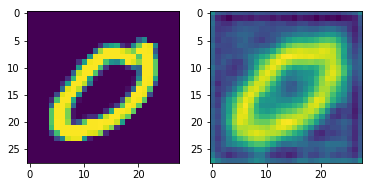

In [8]:
# Plot the input and output (i.e. reconstructed image)
idx = torch.randint(0, output.size(0), ())
pred = min_max_norm(output[idx, 0])
img = data[idx, 0]

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(img.detach().numpy())
axarr[1].imshow(pred.detach().numpy())


### Understanding PyTorch Hooks

Hooks are functions with which you can modify or return different sub-components of your network. Returning the outputs of different layers (i.e. the activations - the goal of this section) is thus an excellent example. In general the point is that they are simply functions that are run whenever the `forward` or `backward` function of a `torch.Autograd.Function` object is called i.e. the `grad_fn` of a tensor (discussed in Lecture 2). 

You can register a function on a `Module` or a `Tensor` and are defined apriori as forward hooks or a backward hooks. Depending on which they are they will either be executed when a forward call is executed (forward hook) or a backward pass in run (backward hook). 

Let's look at using a forward and backward hook just for debugging (and thus printing) the output of a function (example taken from [the official PyTorch tutorials](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html))

A forward hook has the general form:

```python
model.conv_name.register_forward_hook(hook_function(module, input,output))
```

And a backward hook has a general form

```python
model.conv_name.register_backward_hook(hook_function(module,grad_input,grad_output))
```

Say we are interested in layer $l$. A forward hook function can look at inputs and outputs the layer during the forward pass i.e. the input activation from layer $l-1$ and the output activation for layer $l$. The backward pass can look at the inputs and outputs to the backward pass i.e. the incoming (input) gradient with respect to the parameters from the layer above $l+1$ and the outgoing (output) gradient with respect to the parameters of the current layer $l$.

Thus if we wish to print information about the input and output activations we can use:

In [9]:
def printnorm(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print('Inside ' + self.__class__.__name__ + ' forward')
    print('')
    print('input: ', type(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    print('output norm:', output.data.norm())


print_forward_handle=model.conv1.register_forward_hook(printnorm)

# performing forward pass
out = model(data)

Inside Conv2d forward

input:  <class 'tuple'>
input[0]:  <class 'torch.Tensor'>
output:  <class 'torch.Tensor'>

input size: torch.Size([8, 1, 28, 28])
output size: torch.Size([8, 3, 28, 28])
output norm: tensor(122.9414)


And to return backward pass outputs and inputs use:

In [10]:
def printgradnorm(self, grad_input, grad_output):
    print('Inside ' + self.__class__.__name__ + ' backward')
    print('Inside class:' + self.__class__.__name__)
    print('')
    print('grad_input: ', type(grad_input))
    print('grad_input[0]: ', type(grad_input[0]))
    print('grad_output: ', type(grad_output))
    print('grad_output[0]: ', type(grad_output[0]))
    print('')
    print('grad_input size:', grad_input[0].size())
    print('grad_output size:', grad_output[0].size())
    print('grad_input norm:', grad_input[0].norm())


print_backward_handle=model.conv2.register_backward_hook(printgradnorm)

out = model(data)
err = criterion_l1(out, data)
err.backward()

Inside Conv2d forward

input:  <class 'tuple'>
input[0]:  <class 'torch.Tensor'>
output:  <class 'torch.Tensor'>

input size: torch.Size([8, 1, 28, 28])
output size: torch.Size([8, 3, 28, 28])
output norm: tensor(122.9414)
Inside Conv2d backward
Inside class:Conv2d

grad_input:  <class 'tuple'>
grad_input[0]:  <class 'torch.Tensor'>
grad_output:  <class 'tuple'>
grad_output[0]:  <class 'torch.Tensor'>

grad_input size: torch.Size([8, 3, 14, 14])
grad_output size: torch.Size([8, 6, 14, 14])
grad_input norm: tensor(0.0082)


By naming your hooks e.g.

```
print_forward_handle=model.conv1.register_forward_hook(printnorm)

```
it is possible to remove them as:

In [11]:
print_forward_handle.remove()
print_backward_handle.remove()

More information on hooks can be found in https://www.kaggle.com/sironghuang/understanding-pytorch-hooks and https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/ should you be interested.

### Task 2.1. Register hook to get network activations for a given input

Thus hooks are functions that can be applied to the inputs and outputs of our forwards and backwards layers and as such we can use them to return the activations of each layer.

**To do ** Modify the below code to use the hook function `get_activation` to save the activation tensor for the first convolutional layer of your network:

We define the function for you. All you need to do is:

1. Create a (forward or backward) hook 
2. Pass it the hook function `get_activation`. Here, the argument `name` is expecting the name of the layer. Yhe name is what you call the variable in your `__init__` function i.e. `conv1,pool1... ` etc in this instance

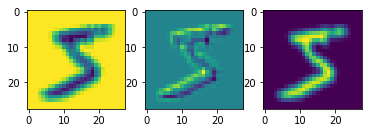

In [12]:

# Set up the hook for activations
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

#--------------------- Task 2.1 ----------------------------#
# Create a hook on the first convolutional layer
#
model.conv1.register_forward_hook(get_activation('conv1'))

#--------------------- ---- ----------------------------#
data, _ = dataset[0]
data.unsqueeze_(0)

# Run through model again, to save the relavent activation
output = model(data)

# Visualize the activation
act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(1, act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])


### Task 2.2: Visualise an activation of another convolutional layer

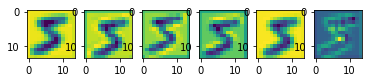

In [13]:
# --------------------------------------------- Task 2 --------------------------------------------------------
# write code here

# Register the hook with the convolutional layer of interest
model.conv2.register_forward_hook(get_activation('conv2'))
data, _ = dataset[0]
data.unsqueeze_(0)

# Run through model again, to save the relavent activation
output = model(data)

# Visualize the activation
act = activation['conv2'].squeeze()
fig, axarr = plt.subplots(1, act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])


### Task 2.3 Explain 

1. How can you interpret the activations of different layers? What does that mean with respect to the relative importance of different parts of your image?

In [38]:
class MNIST_Model(nn.Module):
    def __init__(self):
        super(MNIST_Model, self).__init__()
    
        self.conv1=nn.Conv2d(1, 10, 3)
        self.maxpool1=nn.MaxPool2d(2)
        self.dropout1=nn.Dropout2d()
        
        self.conv2=nn.Conv2d(10, 20, 3)
        self.maxpool2=nn.MaxPool2d(2)
        self.dropout2=nn.Dropout2d()
        
        self.lin_blocks = nn.Sequential(
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            #nn.Softmax(),
        )
        
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = x.view(x.size(0),-1)
        #print(x.shape)
        x = self.lin_blocks(x)

        return F.log_softmax(x,dim=1)

    
net = MNIST_Model() 
print(net)
net = net.to(device)

loss_fun = nn.CrossEntropyLoss()
loss_fun = loss_fun.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)




MNIST_Model(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (lin_blocks): Sequential(
    (0): Linear(in_features=500, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [39]:
epochs = 1
for epoch in range(epochs): 

    # enumerate can be used to output iteration index i, as well as the data 
    for i, (data, labels) in enumerate(loader, 0):
        
        # Task 3.1 load data and labels to device
        data = data.to(device)
        labels = labels.to(device)
        
        # --------------------------------------------------task 2 ------------------------------------------------------------
        # 3.2: implement training iteration here
        # clear the gradient
        optimizer.zero_grad()

        #3.3 feed the input and acquire the output from network
        outputs = net(data)

        #3.4 calculating the predicted and the expected loss
        loss = loss_fun(outputs, labels)

        #3.5 compute the gradient
        loss.backward()

        #3.6 update the parameters
        optimizer.step()
        # ---------------------------------------------------------------------------------------------------------------------

        # print statistics
        ce_loss = loss.item()
        if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))


[1,     1] loss: 2.365
[1,    11] loss: 2.317
[1,    21] loss: 2.285
[1,    31] loss: 2.285
[1,    41] loss: 2.292
[1,    51] loss: 2.283
[1,    61] loss: 2.285
[1,    71] loss: 2.319
[1,    81] loss: 2.323
[1,    91] loss: 2.261
[1,   101] loss: 2.265
[1,   111] loss: 2.337
[1,   121] loss: 2.269
[1,   131] loss: 2.280
[1,   141] loss: 2.300
[1,   151] loss: 2.297
[1,   161] loss: 2.330
[1,   171] loss: 2.310
[1,   181] loss: 2.239
[1,   191] loss: 2.296
[1,   201] loss: 2.201
[1,   211] loss: 2.304
[1,   221] loss: 2.268
[1,   231] loss: 2.319
[1,   241] loss: 2.262
[1,   251] loss: 2.321
[1,   261] loss: 2.266
[1,   271] loss: 2.315
[1,   281] loss: 2.374
[1,   291] loss: 2.221
[1,   301] loss: 2.257
[1,   311] loss: 2.261
[1,   321] loss: 2.261
[1,   331] loss: 2.247
[1,   341] loss: 2.272
[1,   351] loss: 2.282
[1,   361] loss: 2.204
[1,   371] loss: 2.212
[1,   381] loss: 2.347
[1,   391] loss: 2.135
[1,   401] loss: 2.156
[1,   411] loss: 2.260
[1,   421] loss: 2.244
[1,   431] 

[1,  3601] loss: 0.439
[1,  3611] loss: 0.567
[1,  3621] loss: 0.632
[1,  3631] loss: 0.296
[1,  3641] loss: 0.174
[1,  3651] loss: 2.266
[1,  3661] loss: 0.437
[1,  3671] loss: 0.488
[1,  3681] loss: 0.273
[1,  3691] loss: 0.362
[1,  3701] loss: 1.062
[1,  3711] loss: 1.020
[1,  3721] loss: 0.091
[1,  3731] loss: 0.423
[1,  3741] loss: 0.260
[1,  3751] loss: 1.010
[1,  3761] loss: 0.358
[1,  3771] loss: 0.182
[1,  3781] loss: 0.219
[1,  3791] loss: 0.255
[1,  3801] loss: 0.434
[1,  3811] loss: 1.583
[1,  3821] loss: 0.476
[1,  3831] loss: 0.418
[1,  3841] loss: 0.158
[1,  3851] loss: 0.326
[1,  3861] loss: 0.733
[1,  3871] loss: 0.309
[1,  3881] loss: 0.160
[1,  3891] loss: 0.088
[1,  3901] loss: 0.375
[1,  3911] loss: 0.742
[1,  3921] loss: 0.192
[1,  3931] loss: 0.153
[1,  3941] loss: 0.090
[1,  3951] loss: 0.350
[1,  3961] loss: 0.696
[1,  3971] loss: 0.190
[1,  3981] loss: 0.312
[1,  3991] loss: 0.031
[1,  4001] loss: 0.525
[1,  4011] loss: 0.051
[1,  4021] loss: 0.019
[1,  4031] 

[1,  7171] loss: 0.756
[1,  7181] loss: 0.432
[1,  7191] loss: 0.392
[1,  7201] loss: 0.163
[1,  7211] loss: 0.135
[1,  7221] loss: 0.061
[1,  7231] loss: 0.086
[1,  7241] loss: 0.018
[1,  7251] loss: 0.396
[1,  7261] loss: 0.461
[1,  7271] loss: 0.272
[1,  7281] loss: 0.325
[1,  7291] loss: 0.046
[1,  7301] loss: 0.483
[1,  7311] loss: 0.036
[1,  7321] loss: 0.017
[1,  7331] loss: 0.265
[1,  7341] loss: 0.182
[1,  7351] loss: 0.096
[1,  7361] loss: 0.337
[1,  7371] loss: 0.363
[1,  7381] loss: 0.008
[1,  7391] loss: 0.099
[1,  7401] loss: 0.148
[1,  7411] loss: 0.158
[1,  7421] loss: 0.672
[1,  7431] loss: 0.228
[1,  7441] loss: 1.106
[1,  7451] loss: 0.240
[1,  7461] loss: 0.083
[1,  7471] loss: 0.296
[1,  7481] loss: 0.543
[1,  7491] loss: 0.290


20 10


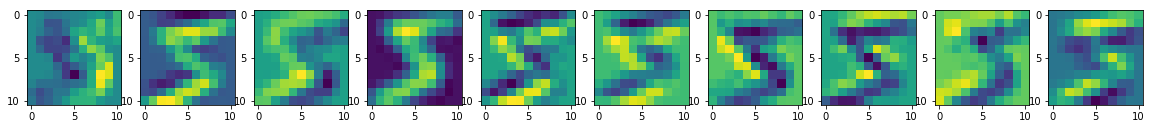

In [52]:

# Set up the hook for activations
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

#--------------------- Task 2.1 ----------------------------#
# Create a hook on the first convolutional layer
#
net.conv2.register_forward_hook(get_activation('conv2'))

#--------------------- ---- ----------------------------#
data, _ = dataset[0]
data.unsqueeze_(0)

# Run through model again, to save the relavent activation
output = net(data)

# Visualize the activation
act = activation['conv2'].squeeze()

print(act.size(0),min(act.size(0),10))
fig, axarr = plt.subplots(1,min(act.size(0),10),figsize=(20,20))
n_plots=min(act.size(0),10)
for idx in np.arange(n_plots):
    axarr[idx].imshow(act[idx])



## Exercise 3: Occlusion

In a related sense we will now try to interpret what our network is doing by occluding different parts/proportions of our image to see what impact this has on classification. Let's return a batch of images from our DataLoader and visualise them

8 torch.Size([1, 28, 28]) tensor(3)


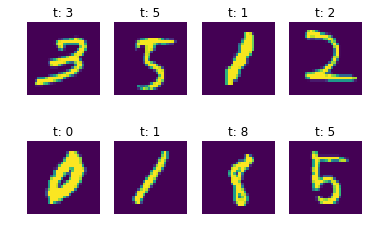

torch.Size([8, 10])
0.9107521176338196 tensor([3, 3, 1, 2, 0, 1, 9, 5])


In [53]:
def plot_MNIST(images,labels):
    rows = 2
    columns = 4
    classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')
    # plot y_score - true label (t) vs predicted label (p)
    fig2 = plt.figure()
    for i in range(8):
        fig2.add_subplot(rows, columns, i+1)
        plt.title('t: ' + classes[labels[i].cpu()])
        img = images[i] / 2 + 0.5     # this is to unnormalize the image
        img = torchvision.transforms.ToPILImage()(img.cpu())
        plt.axis('off')
        plt.imshow(img)
    plt.show()


im_batch, lab_batch=next(iter(loader)) # view one batch

print(len(im_batch),im_batch[0].shape,lab_batch[0])

plot_MNIST(im_batch,lab_batch)

#running inference on the images without occlusion

# pretrained model
outputs = net(im_batch)
print(outputs.shape)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

print(prob_no_occ,pred)

In [196]:
#custom function to conduct occlusion experiments

def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
    print(image.shape,label)
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
    print('wxh',width,height)
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    print('o wxh',output_width,output_height,)
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap

image=im_batch[5].unsqueeze(0)

In [199]:
heatmap = occlusion(net, image, pred[5].item(), 10, 1)

torch.Size([1, 1, 28, 28]) 1
wxh 28 28
o wxh 18 18


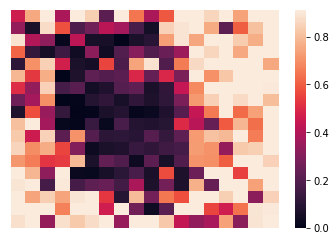

In [200]:
import seaborn as sns

#displaying the image using seaborn heatmap and also setting the maximum value of gradient to probability
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
figure = imgplot.get_figure()    


## Exercise 4: T-SNE embedding

## 3. CNN Layer Visualization

We will go through the next examples using code from the following repository https://github.com/utkuozbulak/pytorch-cnn-visualizations, which implements several well known visualization techniques for deep learning networks.

**CNN layer visualization** technique produces an image that minimizes the loss of a convolutional operation for a specific layer and filter - i.e. it learns the image that optimally activates a particular convolutional filter.

D. Erhan, Y. Bengio, A. Courville, P. Vincent. Visualizing Higher-Layer Features of a Deep Network https://www.researchgate.net/publication/265022827_Visualizing_Higher-Layer_Features_of_a_Deep_Network

**All the visualizations will be saved to** `/generated` folder

In [4]:
# load vgg model, and extract layers from the features modules only
pretrained_model = models.vgg16(pretrained=True).features


In [5]:
print(pretrained_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [7]:
cnn_layer = 21
filter_pos = 5
# Fully connected layer is not needed
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()

# Layer visualization without pytorch hooks
#layer_vis.visualise_layer_without_hooks()


Iteration: 1 Loss: 1.00
Iteration: 2 Loss: 0.54
Iteration: 3 Loss: -4.17
Iteration: 4 Loss: -7.75
Iteration: 5 Loss: -11.51
Iteration: 6 Loss: -14.92
Iteration: 7 Loss: -18.13
Iteration: 8 Loss: -21.20
Iteration: 9 Loss: -24.12
Iteration: 10 Loss: -26.99
Iteration: 11 Loss: -29.80
Iteration: 12 Loss: -32.58
Iteration: 13 Loss: -35.36
Iteration: 14 Loss: -38.08
Iteration: 15 Loss: -40.78
Iteration: 16 Loss: -43.45
Iteration: 17 Loss: -46.11
Iteration: 18 Loss: -48.76
Iteration: 19 Loss: -51.40
Iteration: 20 Loss: -54.00
Iteration: 21 Loss: -56.60
Iteration: 22 Loss: -59.23
Iteration: 23 Loss: -61.84
Iteration: 24 Loss: -64.49
Iteration: 25 Loss: -67.15
Iteration: 26 Loss: -69.82
Iteration: 27 Loss: -72.54
Iteration: 28 Loss: -75.27
Iteration: 29 Loss: -78.05
Iteration: 30 Loss: -80.81


### Task 3: Visualize different CNN layers and filters
Change the CNN layer and filter to visualize the network at different depths

In [ ]:
# --------------------------------------------- Task 3 --------------------------------------------------------
# write code here



## 4. Gradient visualization with Guided backpropagation

In order to visualise what is learnt by neurons in higher layers, a deconvolutional approach was developed, which inverts the data flow of a CNN, going from a neuron of interest to an image. The resulting image is the one which most strongly activates this neuron.

![guided_backprop](guided_backprop.png)

Details of the backprop method is in the following reference:

Springenberg, Jost Tobias, et al. "Striving for simplicity: The all convolutional net." arXiv preprint arXiv:1412.6806 (2014)-
https://arxiv.org/pdf/1412.6806.pdf

You can find the implementation of guided backpropagation in `/visualizations/src/guided_backprop.py`.

First get input image, class label, and pretrained model (pretrained alexnet):

In [5]:
target_example = 0  
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)


Then you create an instance of the guidedbackprop class using `GuidedBackprop(pretrained_model)`. 
This operation creates hooks on the model, which updates relu activation functions so that:
1. it stores the output of the forward pass
2. it imputes zero for gradient values that are less than zero, i.e. all gradients are clamped to zero


In [46]:
print(pretrained_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
#--------------------------------------------------------- Guided backprop---------------------------------------------------
# Guided backprop
GBP = GuidedBackprop(pretrained_model)


 Then you can generate gradients that are specific to a particular input image, and class using the method `GP.generate_gradients()` with the following steps:
 1. go through a forward pass with the image input, and generate an output
 2. backprop through the output
 3. get the gradients from the backprop
 

In [7]:
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)

Then we can save the gradients using the following plotting functions

In [8]:
#--------------------------------------------------------- Save images-------------------------------------------------------
# Save colored gradients
save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
print('Guided backprop completed')


Guided backprop completed


### Task 4: Run guided backprop for different inputs, and classes
You can do this by changing `target_example=` (there's 3 inputs available)


In [ ]:
# --------------------------------------------- Task 4 --------------------------------------------------------
# write code here


## 5. Gradient Class Activation Mapping (grad-CAM)


R. R. Selvaraju, A. Das, R. Vedantam, M. Cogswell, D. Parikh, and D. Batra. Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization, https://arxiv.org/abs/1610.02391

In [30]:
# Get params
target_example = 1
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

# Grad cam
grad_cam = GradCam(pretrained_model, target_layer=11)
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)
# Save mask
save_class_activation_images(original_image, cam, file_name_to_export)
print('Grad cam completed')


Grad cam completed


## 6. Deep Dream


In [6]:
# THIS OPERATION IS MEMORY HUNGRY! #
# Because of the selected image is very large
# If it gives out of memory error or locks the computer
# Try it with a smaller image
cnn_layer = 34
filter_pos = 94

im_path = './visualizations/input_images/dd_tree.jpg'
# Fully connected layer is not needed

dd = DeepDream(pretrained_model, cnn_layer, filter_pos, im_path)
# This operation can also be done without Pytorch hooks
# See layer visualisation for the implementation without hooks
dd.dream()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\cherb/.cache\torch\checkpoints\vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 548M/548M [00:42<00:00, 13.5MB/s]


Iteration: 1 Loss: 2.77
Iteration: 2 Loss: 0.61
Iteration: 3 Loss: -1.57
Iteration: 4 Loss: -5.64
Iteration: 5 Loss: -10.87
Iteration: 6 Loss: -14.60
Iteration: 7 Loss: -19.93
Iteration: 8 Loss: -22.96
Iteration: 9 Loss: -26.42
Iteration: 10 Loss: -36.34
(117, 224, 3)
Iteration: 11 Loss: -44.76
Iteration: 12 Loss: -48.59
Iteration: 13 Loss: -61.83
Iteration: 14 Loss: -68.44
Iteration: 15 Loss: -86.76
Iteration: 16 Loss: -99.98
Iteration: 17 Loss: -108.20
Iteration: 18 Loss: -120.65
Iteration: 19 Loss: -130.63
Iteration: 20 Loss: -140.53
(117, 224, 3)
Iteration: 21 Loss: -161.21
Iteration: 22 Loss: -171.47
Iteration: 23 Loss: -184.46
Iteration: 24 Loss: -197.56
Iteration: 25 Loss: -205.05
Iteration: 26 Loss: -230.14
Iteration: 27 Loss: -250.46
Iteration: 28 Loss: -269.46
Iteration: 29 Loss: -280.43
Iteration: 30 Loss: -294.50
(117, 224, 3)
Iteration: 31 Loss: -307.95
Iteration: 32 Loss: -325.44
Iteration: 33 Loss: -340.58
Iteration: 34 Loss: -361.21
Iteration: 35 Loss: -379.82
Iteration